# Running stardate on simulated stars

Testing the code on data simulated in the Simulate_data.ipynb notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import h5py
import tqdm
import emcee

from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
mist = MIST_Isochrone()

import stardate as sd
from stardate.lhf import lnprob

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the simulated data file and plot it on an HR diagram.

In [2]:
df = pd.read_csv("data/simulated_data.csv")

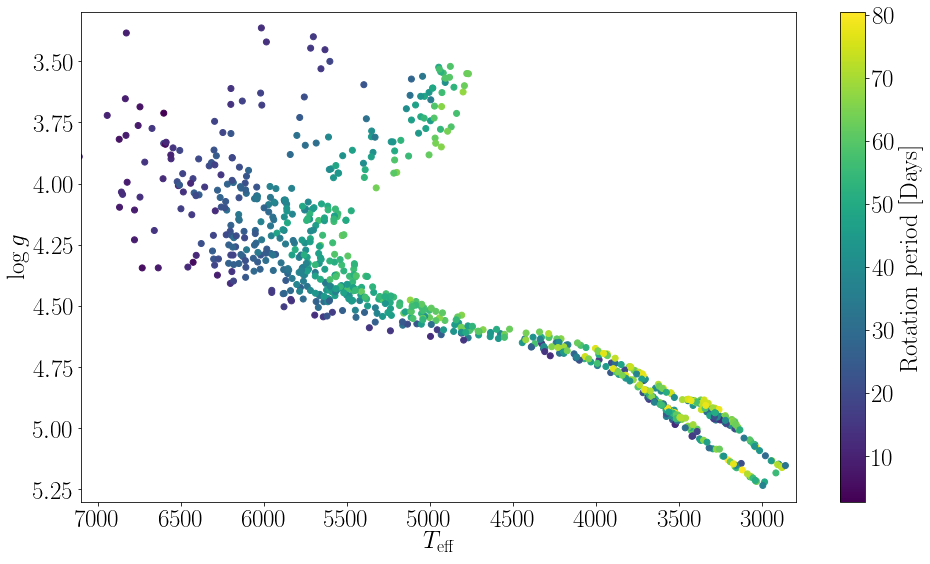

In [3]:
plt.figure(figsize=(16, 9))
plt.scatter(df.teff, df.logg, c=df.prot)
plt.ylim(5.3, 3.3)
plt.xlim(7100, 2800)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log g$")
plt.colorbar(label="$\mathrm{Rotation~period~[Days]}$")

Small observational uncertainties are needed (even though the stars weren't simulated with any) in order to get a good fit.

In [4]:
teff_err = 25  # Kelvin
logg_err = .05  # dex
feh_err = .05  # dex
jmag_err = .01 # mags
hmag_err = .01  # mags
kmag_err = .01  # mags
parallax_err = .05  # milliarcseconds
prot_err = 1  # Days
BV_err = .01  # mags

# Recover stellar parameters of simulated stars

Define the dictionary of observables.

In [5]:
i = 0
iso_params = pd.DataFrame(dict({"teff": (df.teff[i], teff_err),
                                "logg": (df.logg[i], logg_err),
                                "feh": (df.feh[i], feh_err), 
                                "jmag": (df.jmag[i], jmag_err),
                                "hmag": (df.hmag[i], hmag_err),
                                "kmag": (df.kmag[i], kmag_err),
                                "parallax": (df.parallax[i], parallax_err)}))

Test the likelihood function.

In [6]:
i = 1
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, df.prot[i], 1, False]  # the lnprob arguments]

lnparams = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
            np.log(df.d_kpc.values[i]*1e3) + .2, df.Av.values[i]]
bad_lnprob = lnprob(lnparams, *args)
print(bad_lnprob)

lnparams = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
            np.log(df.d_kpc.values[i]*1e3), df.Av.values[i]]
good_lnprob = lnprob(lnparams, *args)
print(good_lnprob)

assert bad_lnprob[0] < good_lnprob[0], "True parameters values must give a higher likelihood than wrong values"

(-188.5795918481113, -24.218255090998852)
(-134.2910398216215, -24.618255090998854)


In [7]:
def gyro_age(period, bv):
    a, b, c, n = [.4, .31, .45, .55]
    return np.log10(((period/(a*(bv-c)**b))**(1./n))*1e6)

def test_gyro_is_on(bv, eep, age, feh, prot):
    if bv < .45:
        print("too hot")
        return False, (10**gyro_age(prot, bv))*1e-9
    if eep > 454:
        print("Evolved")
        return False, (10**gyro_age(prot, bv))*1e-9
    else:
        print("Suitable for gyro")
        return True, (10**gyro_age(prot, bv))*1e-9

Infer ages of the simulated stars. WARNING: this will take a long time to run!

In [ ]:
# The directory where the posterior samples and result plots will be saved.
savedir = "simulation_results/iso_and_gyro"
savedir_iso = "simulation_results/iso_only"

N = len(df)
for i in range(N):
    print(i, "of", N)
    
    status, gage = test_gyro_is_on(df.B[i] - df.V[i], df.eep[i], df.age[i], df.feh[i], df.prot[i])
    print(status, gage, "\n")

    # Set up the parameter dictionary. 
    iso_params = {"teff": (df.teff[i], teff_err),
                  "logg": (df.logg[i], logg_err),
                  "feh": (df.feh[i], feh_err), 
                  "jmag": (df.jmag[i], jmag_err),
                  "hmag": (df.hmag[i], hmag_err),
                  "kmag": (df.kmag[i], kmag_err),
                  "parallax": (df.parallax[i], parallax_err)}
    
    # Infer an age with isochrones and gyrochronology.
    
    # Set up the star object
    star = sd.star(iso_params, df.prot[i], .01, savedir=savedir, suffix=i)
    
    # Run the MCMC
    sampler = star.fit(max_n=50000)

    # Plot the chains and make a corner plot
    # Mass [M_sun], Age [log10(yrs)], [Fe/H] [dex], Distance [ln(pc)], A_v [R: 0-1]
    truths = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
              np.log(df.d_kpc.values[i]*1e3), df.Av.values[i]]
    star.make_plots(truths, burnin=10)
    
    # Now infer an age with isochrones only.
    
    # Set up the star object
    star_iso = sd.star(iso_params, df.prot[i], .01, savedir=savedir_iso, suffix=i)
    
    # Run the MCMC
    sampler = star_iso.fit(iso_only=True)
    
    # Plot the chains and make a corner plot
    truths = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
              df.d_kpc.values[i]*1e3, df.Av.values[i]]
    star_iso.make_plots(truths, burnin=10)

0 of 864
Suitable for gyro
True 4.033026730434735 



  0%|          | 74/50000 [00:00<05:00, 166.10it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
100%|██████████| 50000/50000 [03:38<00:00, 229.11it/s]


nsteps =  500 burnin =  10
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 73/100000 [00:00<07:01, 237.21it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
100%|██████████| 100000/100000 [06:30<00:00, 256.23it/s]


nsteps =  1000 burnin =  10
Plotting age posterior
Plotting production chains...
Making corner plot...


1 of 864
Suitable for gyro
True 3.834213787471984 



  0%|          | 68/50000 [00:00<03:45, 220.96it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
 89%|████████▊ | 44352/50000 [03:12<00:23, 240.21it/s]